In [1]:
import warnings
warnings.filterwarnings('ignore')

В этом задании вам предлагается проанализировать данные одной из американских телекоммуникационных компаний о пользователях, которые потенциально могут уйти.

Измерены следующие признаки:

- state — штат США
- account_length — длительность использования аккаунта
- area_code — деление пользователей на псевдорегионы, использующееся в телекоме
- intl_plan — подключена ли у пользователя услуга международного общения
- vmail_plan — подключена ли у пользователя услуга голосовых сообщений
- vmail_message — количество голосых сообщений, который пользователь отправил / принял
- day_calls — сколько пользователь совершил дневных звонков
- day_mins — сколько пользователь проговорил минут в течение дня
- day_charge — сколько пользователь заплатил за свою дневную активность
- eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
- night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
- intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
- custserv_calls — сколько раз пользователь позвонил в службу поддержки
- treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)
- mes_estim — оценка интенсивности пользования интернет мессенджерами
churn — результат оттока: перестал ли абонент пользоваться услугами оператора


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from tqdm import tqdm
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.multitest import multipletests


In [3]:
path = 'https://raw.githubusercontent.com/chekhovana/courses/main/machine_learning/4_inference/4_practice/data/4.5_churn_analysis.csv'
data = pd.read_csv(path, index_col=0)
data['churn'] = data['churn'].apply(lambda x: 1 if x == 'True.' else 0)
data_control = data[data['treatment'] == 1]
data_treatment_1 = data[data['treatment'] == 0]
data_treatment_2 = data[data['treatment'] == 2]
data.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1,0.65,0
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0.55,0
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0.72,0
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1,0.28,0
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,2,0.45,0


Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.

Для этого мы воспользуемся критерием хи-квадрат. Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn.

In [4]:
states = data['state'].unique()
cross_tabs = []
for state_pair in tqdm(list(combinations(states, 2))):
    df = data_control[data['state'].isin(state_pair)]
    cross_tabs.append(pd.crosstab(df['state'], df['churn']))
len(cross_tabs)

100%|██████████| 1275/1275 [00:18<00:00, 68.82it/s]


1275

In [6]:
pvalues_chi2 = [stats.chi2_contingency(ct, correction=False)[1] for ct in cross_tabs]
print(len([pv for pv in pvalues_chi2 if pv < 0.05]))

34


В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то дискретное биномиальное распределение данных по клеткам в таблице сопряженности может быть аппроксимировано с помощью непрерывного распределения xи-квадрат. Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность. Эта поправка заключается в вычитании константы 0.5 из каждого модуля разности наблюденного  $ O_i$   и ожидаемого $E_i$ значений, то есть, статистика с такой поправкой выглядит так:

$\chi _{\text{Yates}}^{2}=\sum _{i=1}^{N}{(|O_{i}-E_{i}|-0.5)^{2} \over E_{i}}$

Такая поправка, как несложно догадаться по формуле, как правило, уменьшает значение статистики $\chi^{2}$, то есть увеличивает достигаемый уровень значимости.

Эта поправка обычно используется для таблиц сопряженности размером 2x2 и для небольшого количества наблюдений. Такая поправка, однако, не является серебрянной пулей, и часто критикуется за то, что статистический критерий при ее использовании становится слишком консервативным, то есть часто не отвергает нулевую гипотезу там, где она неверна (совершает ошибку II рода).

Полезно знать, что эта поправка часто включена по умолчанию (например, в функции scipy.stats.chi2_contingency) и понимать ее влияние на оценку достигаемого уровня значимости.

Проведите те же самые сравнения, что и в предыдущем вопросе, только с включенной коррекцией

In [9]:
pvalues_chi2_yates = [stats.chi2_contingency(ct, correction=True)[1] for ct in cross_tabs]
print(len([pv for pv in pvalues_chi2_yates if pv < 0.05]))

0


Что если у нас мало данных, мы не хотим использовать аппроксимацию дискретного распределения непрерывным и использовать сомнительную поправку, предположения критерия xи-квадрат не выполняются, а проверить гипотезу о том, что данные принадлежат одному распределению, нужно ?

В таком случае прибегают к так называемому точному критерию Фишера. Этот критерий не использует приближений и в точности вычисляет значение достигаемого уровня значимости используя комбинаторный подход.

Посчитайте для каждой пары штатов, как и в первом задании, достигаемый уровень значимости с помощью точного критерия Фишера и сравните получившиеся значения с двумя другими подходами, описанными выше.

In [ ]:
pvalues_fisher = [stats.fisher_exact(ct)[1] for ct in cross_tabs]
print(len([pv for pv in pvalues_fisher if pv < 0.05]))

In [ ]:
print(np.mean(pvalues_chi2), np.mean(pvalues_chi2_yates), np.mean(pvalues_fisher))

0.5018273798739158 0.6640566382051046 0.6483383060020682


**Вывод: точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем большие, чем xи-квадрат без поправки и меньшие, чем xи-квадрат с поправкой Йетса**

Давайте попробуем применить полученные знания о разных видах корреляции и ее применимости на практике.

Рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Пирсона между этими признаками на всех данных, ее значимость.

In [ ]:
stats.pearsonr(data['day_calls'], data['mes_estim'])

(-0.05179435058757264, 0.0027798836869738384)

**Корреляция Пирсона имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.**

Еще раз рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Спирмена между этими признаками на всех данных, ее значимость.

In [ ]:
stats.spearmanr(data['day_calls'], data['mes_estim'])

SpearmanrResult(correlation=0.043349880533927444, pvalue=0.012317367189170541)

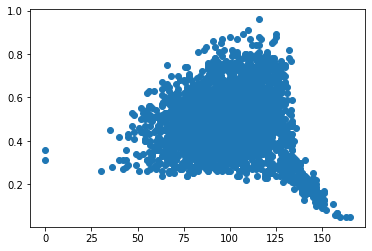

In [ ]:
plt.scatter(data['day_calls'], data['mes_estim'])
plt.show()

**Корреляция Спирмена имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.**

Посчитайте значение коэффицента корреляции Крамера между двумя признаками: штатом (state) и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной группе (treatment=1). Что можно сказать о достигаемом уровне значимости при проверке гипотезы о равенство нулю этого коэффициента?

In [12]:
cont_table = pd.crosstab(data_control['state'], data_control['churn'])
stats.chi2_contingency(cont_table)[1]

0.7097590042778473

**Ответ: для вычисления коэффициента Крамера используется значение статистики xи-квадрат, на которую мы не можем положиться применительно к нашим данным.**

Вы прослушали большой курс и к текущему моменту обладете достаточными знаниями, чтобы попытаться самостоятельно выбрать нужный метод / инструмент / статистический критерий и сделать правильное заключение.

В этой части задания вам нужно будет самостоятельно решить, с помощью каких методов можно провести анализ эффективности удержания (churn) с помощью раличных методов (treatment = 0, treatment = 2) относительно контрольной группы пользователей (treatment = 1).

Что можно сказать об этих двух методах (treatment = 0, treatment = 2)? Одинаковы ли они с точки зрения эффективности? Каким бы методом вы бы посоветовали воспользоваться компании?

Не забудьте про поправку на множественную проверку! И не пользуйтесь односторонними альтернативами, поскольку вы не знаете, к каким действительно последствиям приводят тестируемые методы (treatment = 0, treatment = 2) !

In [ ]:
def get_ratio(vals):
    return sum(vals) / len(vals)

In [ ]:
churn_control = data_control['churn']
churn_treatment_1 = data_treatment_1['churn']
churn_treatment_2 = data_treatment_2['churn']
print(get_ratio(churn_control))
print(get_ratio(churn_treatment_1))
print(get_ratio(churn_treatment_2))

0.1640838650865998
0.14563106796116504
0.12511332728921123


In [ ]:
def get_conf_int(vals):
    return proportion_confint(sum(vals), vals.shape[0], method = 'wilson')

print(get_conf_int(churn_control))
print(get_conf_int(churn_treatment_1))
print(get_conf_int(churn_treatment_2))

(0.14334706983717693, 0.18716506331819044)
(0.1262891297794312, 0.16736787598019826)
(0.1068800961786988, 0.14594875893019524)


In [ ]:
def get_confint_by_prob(p1, p2, n1, n2, alpha=0.05):
    z = stats.norm.ppf(1 - alpha / 2.)
    delta = z * np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
    left_boundary = (p1 - p2) - delta
    right_boundary = (p1 - p2) + delta
    
    return (left_boundary, right_boundary)

def proportions_confint_diff_ind(sample1, sample2, alpha=0.05):    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    return get_confint_by_prob(p1, p2, len(sample1), len(sample2), alpha)
    
print(proportions_confint_diff_ind(churn_control, churn_treatment_1))
print(proportions_confint_diff_ind(churn_control, churn_treatment_2))
print(proportions_confint_diff_ind(churn_treatment_1, churn_treatment_2))

(-0.011583241590025106, 0.04848883584089464)
(0.00961876673809212, 0.06832230885668503)
(-0.007820886720395197, 0.04885636806430281)


In [ ]:
def proportions_test(sample1, sample2):
    p1 = get_ratio(sample1)
    p2 = get_ratio(sample2)
    n1, n2 = len(sample1), len(sample2)
    p = (p1 * n1 + p2 * n2) / (n1 + n2)
    stdev = np.sqrt(p * (1 - p) * (1 / n1 + 1 / n2))
    zscore = np.abs(p1 - p2) / stdev
    pvalue = 1 - stats.norm.cdf(zscore)
    return pvalue

pvalues = []
pvalues.append(proportions_test(churn_control, churn_treatment_1))
pvalues.append(proportions_test(churn_control, churn_treatment_2))
pvalues.append(proportions_test(churn_treatment_2, churn_treatment_1))
pvalues

[0.11416558195225535, 0.0046740421472255544, 0.0782123443025401]

In [ ]:
multipletests(pvalues, alpha=0.025, method='holm')

(array([False,  True, False]),
 array([0.15642469, 0.01402213, 0.15642469]),
 0.008403758659612626,
 0.008333333333333333)

In [ ]:
# another way, from lectures
def get_zscore(sample1, sample2):
    p1 = get_ratio(sample1)
    p2 = get_ratio(sample2)
    n1, n2 = len(sample1), len(sample2)
    zscore = np.abs(p1 - p2) / np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
    pvalue = 1 - stats.norm.cdf(zscore)
    return zscore, pvalue

print(get_zscore(churn_control, churn_treatment_1))
print(get_zscore(churn_control, churn_treatment_2))
;;print(get_zscore(churn_treatment_2, churn_treatment_1))

(1.2041141018126644, 0.11427274008148391)
(2.6022569604653114, 0.004630621596240725)
(1.4190536543777446, 0.07794168708229643)


**Выводы:**

- отличие между treatment = 0 и treatment = 2 относительно влияния на уровень churn статистически незначимо.

- treatment = 2 статистически значимо отличается от контрольной группы treatment = 1